# Introducción a Machine Learning (ML)

## ¿Qué es Machine Learning?

Machine Learning (aprendizaje automático) es una rama de la inteligencia artificial que permite a las computadoras aprender patrones y tomar decisiones a partir de datos, sin ser explícitamente programadas para cada tarea.

En lugar de seguir reglas fijas, un modelo de ML utiliza datos históricos para “aprender” y luego hacer predicciones o clasificaciones sobre datos nuevos.

## Tipos principales de Machine Learning

- **Aprendizaje Supervisado:**  
  El modelo aprende a partir de un conjunto de datos etiquetados, donde cada entrada tiene una salida conocida.  
  Ejemplos: clasificación (activo vs inactivo), regresión (predecir una propiedad continua).

- **Aprendizaje No Supervisado:**  
  El modelo encuentra patrones o agrupamientos en datos sin etiquetas.  
  Ejemplo: clustering para identificar grupos de moléculas similares.

- **Aprendizaje por Refuerzo:**  
  El modelo aprende a tomar decisiones mediante prueba y error, recibiendo recompensas o penalizaciones.

## Componentes clave en ML

- **Datos:** el combustible para el aprendizaje.  
- **Características (features):** representaciones numéricas de los datos que el modelo usa para aprender.  
- **Modelo:** algoritmo matemático que encuentra patrones en los datos.  
- **Función objetivo:** métrica que el modelo optimiza durante el entrenamiento.  
- **Entrenamiento:** proceso de ajustar el modelo a los datos para minimizar errores.  
- **Evaluación:** medir qué tan bien el modelo funciona con datos no vistos.

## Aplicación en Quimioinformática

En quimioinformática, ML se usa para predecir propiedades moleculares, actividad biológica, toxicidad, entre otros, a partir de la estructura química y datos experimentales.



# Datos y Análisis de Datos Químicos

## Introducción: ¿Por qué es importante el tipo de dato?

En quimioinformática y modelado molecular, la calidad y tipo de datos que utilicemos es fundamental, ya que influyen directamente en el desempeño y confiabilidad de nuestros modelos de inteligencia artificial.

No todos los datos son iguales: elegir adecuadamente el tipo de datos y su fuente es clave para obtener resultados robustos y útiles.

## Fuentes de datos

Podemos obtener datos químicos y biológicos de diferentes orígenes:

- **Datos propios:**  
  Resultados experimentales generados en nuestro laboratorio o proyecto. Estos datos suelen ser muy específicos y controlados, pero pueden ser limitados en cantidad.

- **Datos de publicaciones científicas:**  
  Información reportada en artículos y trabajos de investigación. Es importante validar la calidad y contexto de estos datos antes de usarlos.

- **Bases de datos públicas:**  
  Repositorios como ChEMBL, PubChem que almacenan miles o millones de compuestos con sus propiedades y resultados de bioensayos.

## Tipos de datos y su impacto

Los datos químicos y biológicos pueden venir en diferentes formatos y contextos, por ejemplo:

- **Estructuras moleculares:**  
  Generalmente representadas como SMILES o InChI, son la base para cualquier análisis y modelado.

- **Bioactividad:**  
  Indican si una molécula es activa o inactiva frente a un target o ensayos específicos. Esta información puede variar según el tipo de bioensayo utilizado.

- **Tipos de bioensayos:**  
  Cada tipo de ensayo mide diferentes aspectos biológicos o farmacológicos, como:

  - Ensayos de inhibición enzimática (p.ej. IC50, Ki)  
  - Ensayos celulares funcionales  
  - Ensayos fenotípicos  
  - Ensayos toxicológicos

La selección del tipo de bioensayo afecta la definición de “actividad” y por lo tanto el etiquetado de los datos para el entrenamiento del modelo.

## Importancia de la correcta selección y curación de datos

- **Consistencia:**  
  Es clave que los datos provengan de ensayos comparables para evitar introducir ruido o sesgo.

- **Cantidad vs calidad:**  
  A veces hay que balancear tener muchos datos con tener datos confiables y bien caracterizados.

- **Preprocesamiento y validación:**  
  Limpieza, filtrado y normalización son pasos imprescindibles para preparar los datos antes de modelar.


# Ejemplos de Uso de Machine Learning en Quimioinformática con Referencias

Machine Learning tiene múltiples aplicaciones en quimioinformática. A continuación se listan ejemplos con publicaciones destacadas que los respaldan:

FALTA!




In [33]:
!pip install pandas scikit-learn rdkit matplotlib seaborn xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.3/124.9 MB 6.1 MB/s eta 0:00:21
   - -------------------------------------- 3.1/124.9 MB 7.4 MB/s eta 0:00:17
   - -------------------------------------- 4.2/124.9 MB 7.9 MB/s eta 0:00:16
   -- ------------------------------------- 6.3/124.9 MB 7.6 MB/s eta 0:00:16
   -- ------------------------------------- 7.3/124.9 MB 7.4 MB/s eta 0:00:16
   -- ------------------------------------- 8.4/124.9 MB 7.4 MB/s eta 0:00:16
   --- ------------------------------------ 10.5/124.9 MB 7.3 MB/s eta 0:00:16
   --- ------------------------------------ 11.5/124.9 MB 7.0 MB/s eta 0:00:17
   ---- ----------------------------------- 12.6/124.9 MB 7.1 MB/s eta 0:00:16
   ---- ----------------------------------- 14.7/124.9 MB 6.8 MB/s eta 0:00:17
   ----- ---------------------------------- 15.7/124.9 MB 6.6 MB/s eta 0:00:17
   ----- ---------------------------------- 16.8/124.9 MB 6.5 MB/s

In [ ]:
import pandas as pd
df = pd.read_csv("../data/AID_1885.csv")
df = df[['PUBCHEM_ACTIVITY_OUTCOME','PUBCHEM_EXT_DATASOURCE_SMILES']]
df = df.dropna().reset_index(drop=True)
df.head()

C:\Users\Merce\AppData\Local\Temp\ipykernel_18980\2766749707.py:2: DtypeWarning: Columns (0,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/AID_1885.csv")


,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,REPRODUCIBILITY_COSINE_TRANSFORM,BROAD_SCREENING_RUNIDS,REPLICATE_A_ACTIVITY_SCORE,REPLICATE_B_ACTIVITY_SCORE,REPLICATE_C_ACTIVITY_SCORE,REPLICATE_D_ACTIVITY_SCORE,DATE_REPORTED
0,RESULT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOAT,STRING,FLOAT,FLOAT,FLOAT,FLOAT,STRING
1,RESULT_DESCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A measure of how well the activity reproduced ...,This is a comma separated list of unique IDs g...,The calculated activity score of the indicated...,The calculated activity score of the indicated...,The calculated activity score of the indicated...,The calculated activity score of the indicated...,Date data reported internally
2,RESULT_UNIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE,NaN,PERCENT,PERCENT,PERCENT,PERCENT,NaN
3,1,24808891.0,851309.0,C1CCCN(CC1)C(=O)CS(=O)(=O)C2=CC3=CC=CC=C3C=C2,Inactive,7.0,NaN,NaN,0.864,"2017-01-A01-10-03, 2017-01-A03-11-01",10.2559,8.19272,10.008,0.066877,7/20/2009
4,2,24809176.0,3155655.0,COC1=CC=CC=C1NC(=O)CC2C(=O)NC3=CC=CC=C3N2C(=O)...,Inactive,-6.0,NaN,NaN,0.373,"2017-01-A01-10-03, 2017-01-A03-11-01",0.77948,14.0952,-18.5938,-18.4761,7/20/2009


Columnas del DataFrame:
Index(['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_EXT_DATASOURCE_SMILES'], dtype='object')

Primeras filas:
  PUBCHEM_ACTIVITY_OUTCOME                      PUBCHEM_EXT_DATASOURCE_SMILES
0                 Inactive      C1CCCN(CC1)C(=O)CS(=O)(=O)C2=CC3=CC=CC=C3C=C2
1                 Inactive  COC1=CC=CC=C1NC(=O)CC2C(=O)NC3=CC=CC=C3N2C(=O)...
2                 Inactive  COC1=C(C=CC(=C1)CNCCNC(=O)C2=NON=C2N)OCC3=CC=C...

Valores nulos por columna:
PUBCHEM_ACTIVITY_OUTCOME         0
PUBCHEM_EXT_DATASOURCE_SMILES    0
dtype: int64


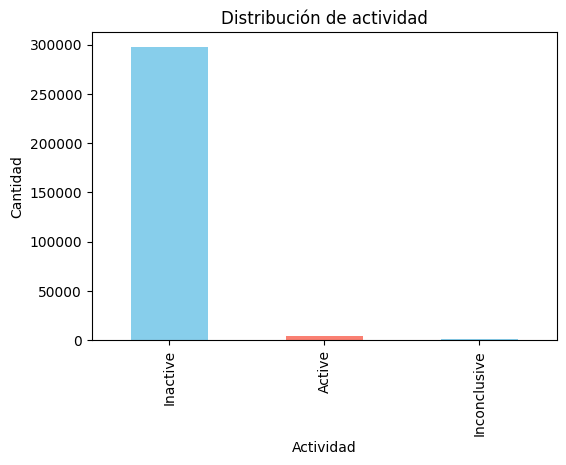


Estadísticas de longitud de SMILES:
count    303286.000000
mean         49.469422
std          11.919386
min           8.000000
25%          41.000000
50%          49.000000
75%          57.000000
max         276.000000
Name: smiles_length, dtype: float64


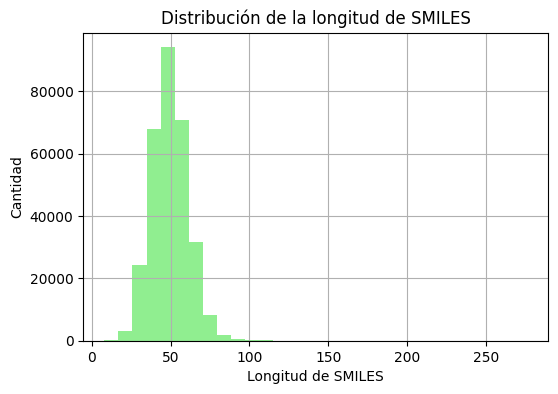

In [ ]:
# Visualización rápida
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['PUBCHEM_ACTIVITY_OUTCOME'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de actividad')
plt.xlabel('Actividad')
plt.ylabel('Cantidad')
plt.show()



[18:47:31] WARNING: not removing hydrogen atom without neighbors
[18:47:31] WARNING: not removing hydrogen atom without neighbors


Cantidad de activos: 4396
Cantidad de inactivos muestreados: 4396
Tamaño total dataset balanceado: 8792


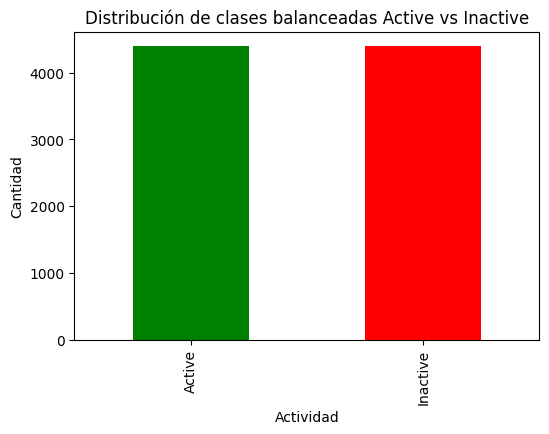

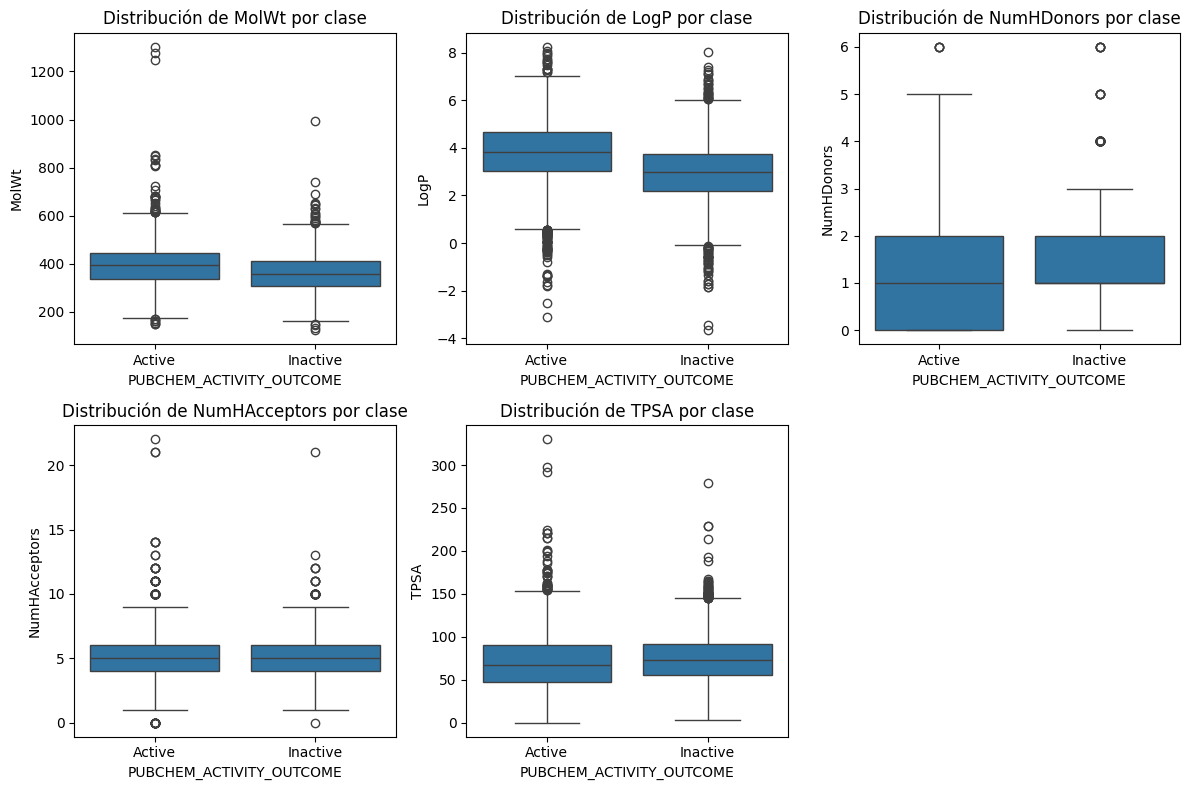

In [22]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Filtrar solo Active e Inactive
df_filtered = df[df['PUBCHEM_ACTIVITY_OUTCOME'].isin(['Active', 'Inactive'])].copy()
df_filtered.reset_index(drop=True, inplace=True)

# Paso 2: Procesar SMILES y crear objetos Mol (RDKit)
def mol_from_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

df_filtered['mol'] = df_filtered['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(mol_from_smiles)
df_filtered = df_filtered[df_filtered['mol'].notnull()].copy()
df_filtered.reset_index(drop=True, inplace=True)

# Paso 3: Balancear dataset con muestreo aleatorio de inactivos para igualar cantidad de activos
actives = df_filtered[df_filtered['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']
inactives = df_filtered[df_filtered['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive']

n_actives = len(actives)
inactives_sampled = inactives.sample(n=n_actives, random_state=42)  # Fijamos semilla para reproducibilidad

df_balanced = pd.concat([actives, inactives_sampled]).reset_index(drop=True)

print(f"Cantidad de activos: {len(actives)}")
print(f"Cantidad de inactivos muestreados: {len(inactives_sampled)}")
print(f"Tamaño total dataset balanceado: {len(df_balanced)}")

# Paso 4: Calcular propiedades fisicoquímicas básicas
def calc_properties(mol):
    return {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol)
    }

props = df_balanced['mol'].apply(calc_properties)
props_df = pd.DataFrame(list(props))
df_balanced = pd.concat([df_balanced, props_df], axis=1)

# Paso 5: Visualizar distribución de clases balanceadas
plt.figure(figsize=(6,4))
df_balanced['PUBCHEM_ACTIVITY_OUTCOME'].value_counts().plot(kind='bar', color=['green','red'])
plt.title('Distribución de clases balanceadas Active vs Inactive')
plt.xlabel('Actividad')
plt.ylabel('Cantidad')
plt.show()

# Paso 6: Visualización de propiedades por clase balanceadas
plt.figure(figsize=(12,8))
for i, prop in enumerate(['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='PUBCHEM_ACTIVITY_OUTCOME', y=prop, data=df_balanced)
    plt.title(f'Distribución de {prop} por clase')
plt.tight_layout()
plt.show()



# Representación y Featurización de Moléculas

## ¿Por qué es importante la representación de las moléculas?

Una vez que hemos obtenido y curado nuestros datos químicos y bioactivos, el siguiente paso crítico es cómo representamos esas moléculas para que los algoritmos de Machine Learning puedan entenderlas y trabajar con ellas.

La representación o **featurización** convierte la estructura química en vectores numéricos o características que describen aspectos relevantes de las moléculas.

## Tipos comunes de featurización

- **Fingerprints (huellas moleculares):**  
  Representaciones binarias o numéricas que codifican la presencia o ausencia de subestructuras químicas, patrones o fragmentos.  
  Ejemplos:  
  - *Morgan fingerprints* (circular)  
  - *MACCS keys*  
  - *Topological fingerprints*

- **Descriptores fisicoquímicos:**  
  Valores numéricos que representan propiedades moleculares calculadas o experimentales, como:  
  - Peso molecular  
  - LogP (lipofilicidad)  
  - Número de átomos de hidrógeno donadores y aceptores  
  - Número de rotaciones libres  
  - Polaridad, etc.

- **Representaciones basadas en gráficos:**  
  Modelos más complejos que consideran la estructura molecular como un grafo (nodos y enlaces) para modelos de Deep Learning.

## ¿Cómo elegir la mejor forma de featurizar?

- Depende del **tipo de modelo** que usarás: algunos modelos funcionan mejor con fingerprints, otros con descriptores, y los modelos de deep learning pueden usar representaciones más complejas.  
- Depende de la **cantidad y calidad de datos**: con pocos datos, las representaciones simples pueden ser más robustas.  
- Depende del **problema y la tarea específica**: por ejemplo, predicción de actividad biológica, propiedades fisicoquímicas, etc.  
- La **interpretabilidad** también es clave: algunos descriptores permiten entender mejor qué propiedades influyen en la predicción.


In [24]:
df_balanced = df_balanced.sample(n=100, random_state=42).reset_index(drop=True)


In [30]:
from rdkit.Chem import AllChem, MACCSkeys, rdFingerprintGenerator
import numpy as np

# Función para convertir fingerprint a numpy array
def fp_to_array(fp):
    arr = np.zeros((fp.GetNumBits(),), dtype=int)
    Chem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Morgan Fingerprints (radius=2, 1024 bits)
df_balanced['fp_morgan'] = df_balanced['mol'].apply(
    lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024)
)
df_balanced['fp_morgan_array'] = df_balanced['fp_morgan'].apply(fp_to_array)

# RDKit Fingerprints (default params)
df_balanced['fp_rdkit'] = df_balanced['mol'].apply(lambda m: Chem.RDKFingerprint(m))
df_balanced['fp_rdkit_array'] = df_balanced['fp_rdkit'].apply(fp_to_array)

# MACCS Keys (166 bits)
df_balanced['fp_maccs'] = df_balanced['mol'].apply(lambda m: MACCSkeys.GenMACCSKeys(m))
df_balanced['fp_maccs_array'] = df_balanced['fp_maccs'].apply(fp_to_array)

# Topological Torsion Fingerprints (usando nuevo generador)
topo_generator = rdFingerprintGenerator.GetTopologicalTorsionGenerator()
df_balanced['fp_topological_torsion'] = df_balanced['mol'].apply(lambda m: topo_generator.GetFingerprint(m))
df_balanced['fp_topological_torsion_array'] = df_balanced['fp_topological_torsion'].apply(fp_to_array)

# Atom Pair Fingerprints (usando nuevo generador)
atompair_generator = rdFingerprintGenerator.GetAtomPairGenerator()
df_balanced['fp_atom_pair'] = df_balanced['mol'].apply(lambda m: atompair_generator.GetFingerprint(m))
df_balanced['fp_atom_pair_array'] = df_balanced['fp_atom_pair'].apply(fp_to_array)



[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerator
[18:58:51] DEPRECATION WARNING: please use MorganGenerat

# Elección del Modelo de Inteligencia Artificial

## ¿Por qué es importante elegir el modelo correcto?

La selección del modelo de Machine Learning o Deep Learning adecuado es clave para obtener predicciones precisas y confiables en tareas de quimioinformática. Diferentes modelos tienen ventajas y limitaciones según el tipo de datos, tamaño del dataset y complejidad del problema.

## Factores a considerar para elegir el modelo

- **Cantidad de datos disponibles:**  
  - Con grandes volúmenes de datos, los modelos de Deep Learning (como redes neuronales convolucionales o grafos neuronales) pueden capturar patrones complejos.  
  - Con pocos datos, modelos tradicionales como Random Forest, Support Vector Machines o regresión logística suelen ser más robustos y menos propensos al sobreajuste.

- **Tipo y complejidad de las características:**  
  - Para descriptores simples o fingerprints, modelos clásicos funcionan bien.  
  - Para representaciones basadas en grafos o secuencias, modelos basados en Deep Learning pueden ser más adecuados.

- **Interpretabilidad:**  
  - Modelos como Random Forest o regresiones permiten interpretar qué variables influyen en la predicción.  
  - Redes neuronales profundas suelen ser “cajas negras” y requieren técnicas adicionales para interpretarlas.

- **Tiempo y recursos computacionales:**  
  - Modelos simples entrenan y predicen rápidamente.  
  - Modelos complejos necesitan más poder de cómputo y tiempo de entrenamiento.

## Ejemplos comunes de modelos para quimioinformática

- **Random Forest:** Popular para clasificación y regresión, fácil de usar y robusto.  
- **Support Vector Machines (SVM):** Bueno para datasets medianos con alta dimensionalidad.  
- **Redes Neuronales Artificiales (ANN):** Flexibles, usadas con fingerprints o descriptores.  
- **Redes Neuronales Convolucionales (CNN):** Para datos con estructura espacial, como imágenes o secuencias.  
- **Modelos basados en Grafos:** Para representar directamente la estructura molecular.



In [36]:
df_balanced.columns

Index(['PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_EXT_DATASOURCE_SMILES',
       'smiles_length', 'mol', 'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
       'TPSA', 'fp_morgan', 'fp_rdkit', 'fp_maccs', 'fp_topological_torsion',
       'fp_atom_pair', 'fp_morgan_array', 'fp_rdkit_array', 'fp_maccs_array',
       'fp_topological_torsion_array', 'fp_atom_pair_array'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

df_balanced['activity'] = df_balanced['PUBCHEM_ACTIVITY_OUTCOME'].str.lower().map({'active': 1, 'inactive': 0})

# Seleccionar la representación (ej: Morgan)
X = np.stack(df_balanced['fp_morgan_array'].values)
y = df_balanced['activity'].values  

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# 2. SVM (con kernel lineal)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# 3. XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Random Forest Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.75      0.55      0.63        11

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20

SVM Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.73      0.73      0.73        11

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20

XGBoost Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.70      0.64      0.67        11

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weig

c:\Users\Merce\miniconda3\envs\curso_quimioinformatica_ai\lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


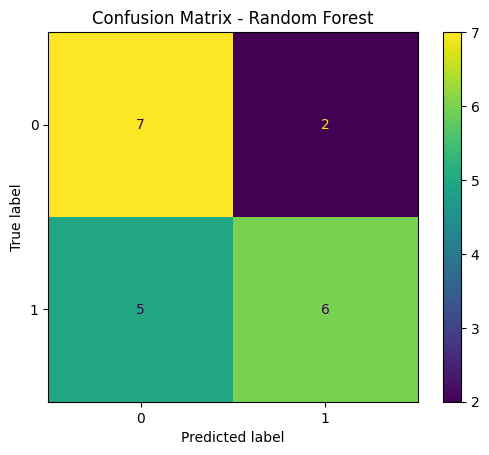

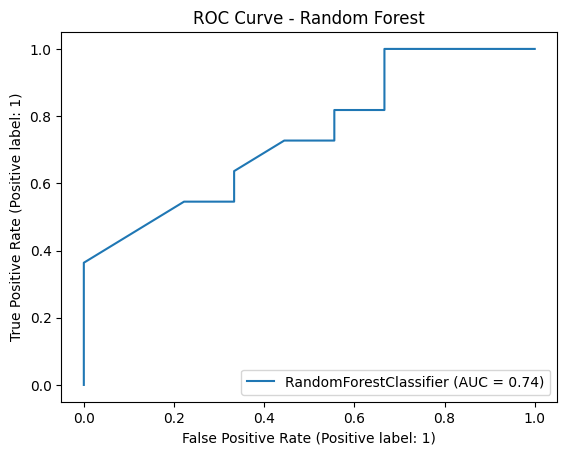

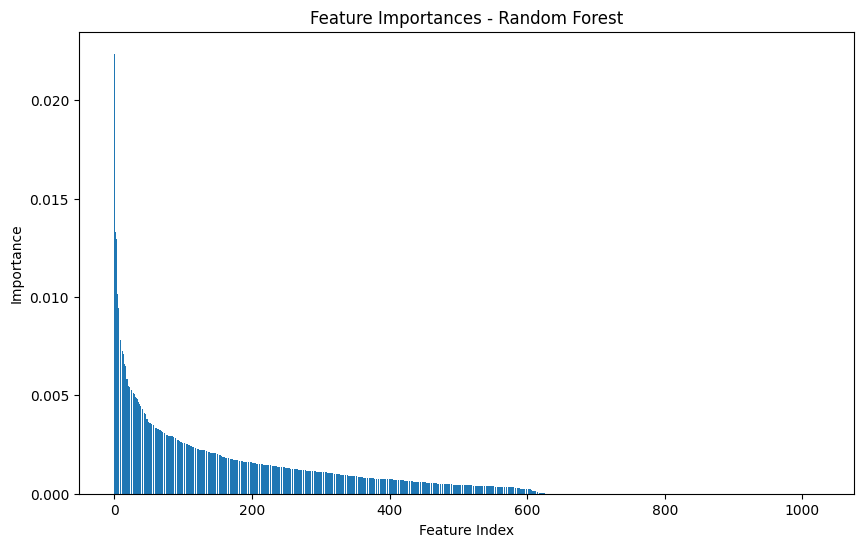

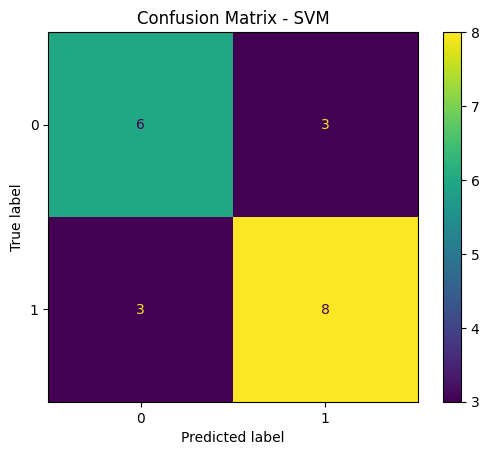

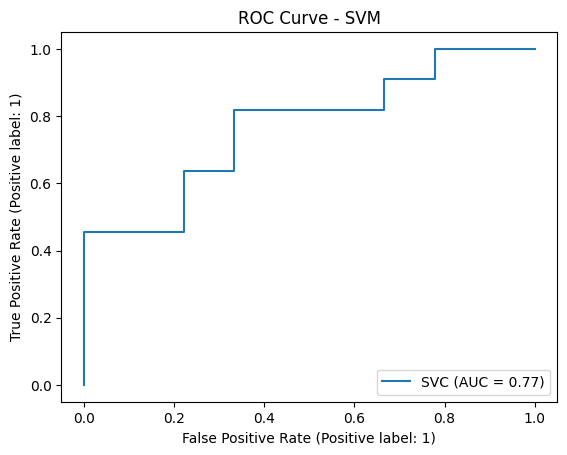

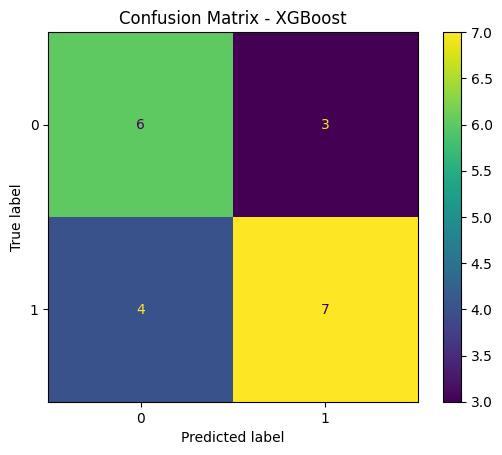

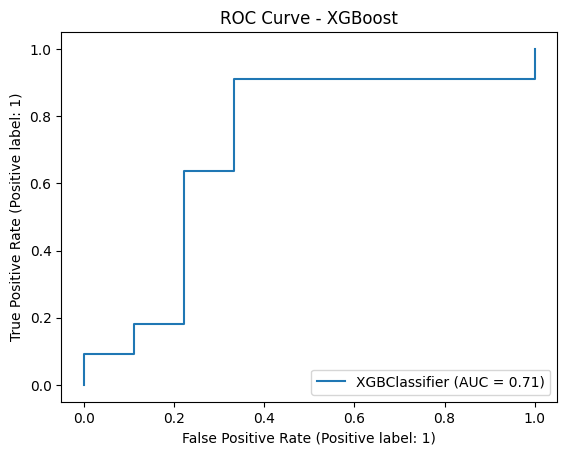

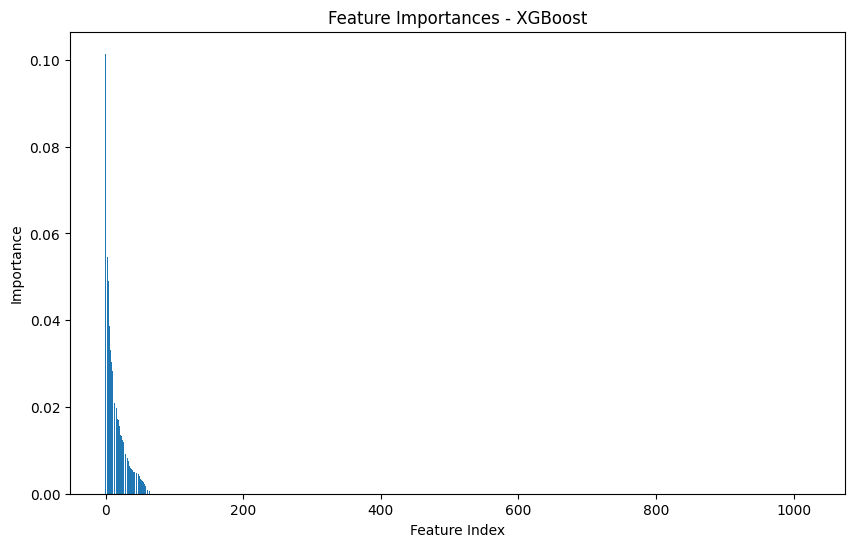

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Función para plotear matriz de confusión y ROC para un modelo dado
def plot_model_performance(model, X_test, y_test, model_name):
    # Matriz de confusión
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()

# 1. Random Forest
plot_model_performance(rf, X_test, y_test, "Random Forest")

# Importancia de features Random Forest
importances_rf = rf.feature_importances_
indices_rf = importances_rf.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# 2. SVM
plot_model_performance(svm, X_test, y_test, "SVM")

# Nota: SVM no tiene importancia de features directa.

# 3. XGBoost
plot_model_performance(xgb_model, X_test, y_test, "XGBoost")

# Importancia de features XGBoost
importances_xgb = xgb_model.feature_importances_
indices_xgb = importances_xgb.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances - XGBoost")
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb], align='center')
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


In [7]:
# Modelos no supervisados


In [8]:
# Modelos supervisados simples

In [9]:
# Modelos supervisados usando herramientas publicadas

# Trabajo en grupo
Ahora vamos a dividirnos en grupos y comprar las diferentes features con los diferentes modelos:
- Grupo 1 : 

Comparar los resultaods obtenidos

# Consideraciones Generales y Cómo Colaborar

## Aspectos clave a tener en cuenta durante el desarrollo

- **Desbalance de datos:**  
  En problemas de clasificación de actividad biológica, es común que haya muchos más compuestos inactivos que activos (o viceversa). Este desbalance puede afectar negativamente el desempeño del modelo y provocar sesgos.  
  **Estrategias:** usar técnicas de balanceo como oversampling (SMOTE), undersampling, o ajustar métricas y umbrales.

- **Similitud intra e inter grupos:**  
  Evaluar la similitud química dentro del grupo de activos y dentro del de inactivos, así como entre ambos grupos, es importante para entender la diversidad y la dificultad del problema.  
  Esto ayuda a definir si el modelo podrá generalizar o si existen subgrupos muy distintos.

- **Definir un baseline:**  
  Es fundamental establecer un modelo o método base sencillo (baseline) para comparar el desempeño de modelos más complejos.  
  Ejemplo: un modelo que siempre predice la clase mayoritaria o usa una métrica simple para referencia.

## Cómo ayudar y colaborar en el proyecto

- **Reportar issues y bugs:**  
  Si encontrás errores o comportamientos inesperados, abrir un issue en GitHub con detalles claros.

- **Contribuir con código:**  
  Crear ramas feature para nuevas funcionalidades o mejoras, y hacer Pull Requests (PR) para revisión.

- **Documentar cambios:**  
  Mantener actualizado el README, comentarios en código y documentación general.

- **Compartir ideas y feedback:**  
  Discutir mejoras, nuevas funcionalidades o problemas en reuniones o a través de los canales designados.




# Retos y Problemas Comunes en Modelado de IA para Quimioinformática

Además de los puntos básicos, estos son algunos desafíos específicos que suelen presentarse al trabajar con datos químicos y biológicos para modelado con IA:

- **Calidad y ruido en los datos:**  
  Resultados experimentales pueden contener errores, inconsistencias o datos contradictorios, afectando la calidad del modelo.

- **Representación molecular incompleta o insuficiente:**  
  No siempre las representaciones estándar capturan toda la complejidad química necesaria para predecir actividad o propiedades.

- **Sobrerrepresentación de ciertas clases químicas:**  
  Algunas familias moleculares pueden estar sobrerrepresentadas, lo que puede sesgar el modelo hacia ellas.

- **Overfitting por poca diversidad química:**  
  Si los datos son demasiado similares, el modelo aprende patrones poco generales y falla en predecir compuestos nuevos.

- **Transferibilidad y generalización:**  
  Modelos que funcionan bien en un conjunto de datos pueden no generalizar a otros targets, ensayos o condiciones.

- **Interpretabilidad limitada:**  
  Los modelos complejos pueden ser difíciles de interpretar, complicando la extracción de conocimiento químico.

- **Escasez de datos para targets poco estudiados:**  
  Muchos blancos biológicos tienen pocos datos disponibles, limitando el entrenamiento de modelos fiables.

- **Desbalance de clases:**  
  Como mencionamos, el desbalance entre activos e inactivos afecta la evaluación y entrenamiento.

- **Problemas en la integración de múltiples fuentes de datos:**  
  Fusionar datos de distintas bases o tipos de ensayos puede ser complejo por diferencias en formatos, condiciones y calidad.

